# Labeling Disaster-Related Messages

### Problem
Given text data of disaster-related messages and news bulletins (English / English translation), can we correctly assign labels to the message?

<img src='./images/wordcloud.png'>

> The task will involve **Natural Language Processing** (*NLP*) analysis.

https://appen.com/datasets/combined-disaster-response-data/

### Objective
Our goal is to create a model that can interpret and label a message using **Natural Language Processing**. There are **37** important labels that a message can have (for example if the message is *requesting medical help* or *offering aid*).

In order to simplify the given dataset, I will be working only with a single label: `aid-related`.

> **Question:** Can we create a model that can correctly label a message as being **aid-related** using only the message itself?

### Success Criteria
We will be using `recall_score`, `precision_score`, `f1-score`, and `accuracy_score` to assess our models.
***
#### Metrics & Loss
##### Recall Score
The recall score of a prediction is the ratio of **correct true positives** to **total positive samples**. *Recall only considers the correctness of samples that are actually `true`.*
> $\LARGE {Recall} = \frac{TP}{TP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/2 (0.5) true positives correctly labeled.
>>> recall_score(y_true, y_pred)
0.5
```
***
##### Precision Score
The precision score of a prediction is the ratio of **correct positive predictions** to **total positive predictions.** *Precision only considers samples where the prediction is `true`.*
> $\LARGE {Precision} = \frac{TP}{TP + FP}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/3 (0.33) predicted positives are correctly labeled.
>>> precision_score(y_true, y_pred)
0.3333333333333333
```
***
##### F1-Score
> *Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.*
>
> *The F-measure (and measures) can be interpreted as a weighted harmonic mean of the precision and recall.*
> https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
> 
> $\LARGE {f_1} = 2 \times \frac{precision \times recall}{precision + recall}$


```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 2 * ((0.333 * 0.5) / (0.333 + 0.5)) = 0.3999759990399616
>>> f1_score(y_true, y_pred)
0.4
```
***
##### Accuracy Score
The accuracy of a prediction is the ratio of **correct labels** to **total labels**. *The accuracy takes into account all of the models predictions, but can be misleading with imbalanced label distributions.*
> 
> $\LARGE {accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

```python
>>> y_true = np.array([0, 0, 1, 1])
>>> y_pred = np.array([1, 1, 0, 1])
>>> 
>>> # 1/4 (0.25) correctly labeled predictions.
>>> accuracy_score(y_true, y_pred)
0.25
```
***
##### Binary Cross-Entropy
Binary Cross-Entropy (*log-loss*) measures the loss based on how wrong the model's predictions are.

Unlike other metrics used, Binary Cross-Entropy is able to measure continuous entries rather than just binary.

$\LARGE {cross entropy} = -\sum_{c=1}^My_{o,c}\log(p_{o,c})$

> *Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.*
>
> *https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html*

```python
>>> # For samples guessed relatively close to the actual values, the log loss will be low.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.15, 0.15, 0.9 , 1.  ])
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
0.1075995070620419

>>> # However, bad predictions will have a large effect on the loss.
>>> y_true = np.array([0.  , 0.  , 1.  , 1.  ])
>>> y_pred = np.array([0.85, 0.15, 0.9 , 1.  ]) # First guess is very off.
>>> 
>>> binary_crossentropy(y_true, y_pred).numpy()
0.5412496336542204
```

Again, ***a perfect model would have a log loss of 0.***

### Imports

In [1]:
import sys

# the ./support dir contains disaster_response.py
sys.path.append('./support')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline

import os
import html
import string
from PIL import Image
from IPython.display import clear_output
import joblib
import re

from gensim.models import Word2Vec, KeyedVectors

from sklearn.metrics import (f1_score, recall_score, 
                             precision_score, accuracy_score)

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight

import tensorflow as tf
from tensorflow.keras import (
    layers, models, initializers, regularizers, constraints, optimizers
)
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

import spacy

import kerastuner as kt

# Custom functions and classes for this project.
import disaster_response as dis 

In [3]:
# Check that GloVe model exists in the correct directory.
dis.check_for_glove()

# Plot formatting.
plt.style.use(['ggplot', 'seaborn-talk'])

# Set colors for plotting.
COLORS = {
    'blue': '#1f77b4',
    'green': '#2eb41f',
    'yellow': '#b4b21f',
    'red': '#b41f1f',
    'purple': '#b41f94',
    'grey': '#e5e5e5'
}

# Set random seed.
tf.random.set_seed(2020)
tf.compat.v1.set_random_seed(2020)

# Check for device.
print(dis.headerize(tf.test.gpu_device_name()))

# Initialize results_df
results_df = dis.make_scores_df()

********************************************************************************
*                         SUCCESS - GloVe Model Found                          *
********************************************************************************
********************************************************************************
*                                /device:GPU:0                                 *
********************************************************************************
********************************************************************************
*                        DataFrame Created Sucessfully                         *
********************************************************************************


In [4]:
# Function to add scores to results_df.
def assign_scores(df, column_name, scores):
    df[column_name] = scores
    return df

# Data Processing

## Understanding
### Load in data.

In [5]:
# Checking that the necessary files are in the default directory.
os.listdir('./data/')

['.ipynb_checkpoints',
 'column_descriptions.csv',
 'disaster_response_messages_test.csv',
 'disaster_response_messages_training.csv',
 'disaster_response_messages_validation.csv']

In [6]:
# Load in data.
dw = dis.DataWarehouse()

********************************************************************************
*                           Data loaded sucessfully.                           *
********************************************************************************
********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Training Data:
	(21046, 42)
Val Data:
	(2573, 42)
Test Data:
	(2629, 42)

Column Descriptions:
	(20, 1)


### Explore data.

In [7]:
dw.train.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [8]:
dw.train['message'].head(10).values

array(['Weather update - a cold front from Cuba that could pass over Haiti',
       'Is the Hurricane over or is it not over',
       'says: west side of Haiti, rest of the country today and tonight',
       'Information about the National Palace-',
       'Storm at sacred heart of jesus',
       'Please, we need tents and water. We are in Silo, Thank you!',
       'I would like to receive the messages, thank you',
       "There's nothing to eat and water, we starving and thirsty.",
       'I am in Petionville. I need more information regarding 4636',
       'I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks'],
      dtype=object)

In [9]:
dw.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
id                        21046 non-null int64
split                     21046 non-null object
message                   21046 non-null object
original                  8191 non-null object
genre                     21046 non-null object
related                   21046 non-null int64
PII                       21046 non-null int64
request                   21046 non-null int64
offer                     21046 non-null int64
aid_related               21046 non-null int64
medical_help              21046 non-null int64
medical_products          21046 non-null int64
search_and_rescue         21046 non-null int64
security                  21046 non-null int64
military                  21046 non-null int64
child_alone               21046 non-null int64
water                     21046 non-null int64
food                      21046 non-null int64
shelter                   21046 non-null i

- There are a couple columns that are strings (that we'll be working with with NLP).
```python
['message', 'genre']
```
- There are many missing values in the `original` column.
- There is an `id` column which can be dropped.
- There are 37 potential target columns (labels) that are binary.

In [10]:
dw.train['genre'].value_counts()

news      10450
direct     8666
social     1930
Name: genre, dtype: int64

In [11]:
# Check the integrity of the `message` column when the `original` is missing.
dw.train[dw.train['original'].isna()]['message'].head()

5973             NOTES: It mark as not enough information
7956    My thoughts and prayers go out to all the live...
7957    lilithia yes 5.2 magnitude earthquake hit mani...
7958    RT TheNewsBlotter RT caribnews On Call Interna...
7959    Most Eureka homeowners won&#39 t collect on qu...
Name: message, dtype: object

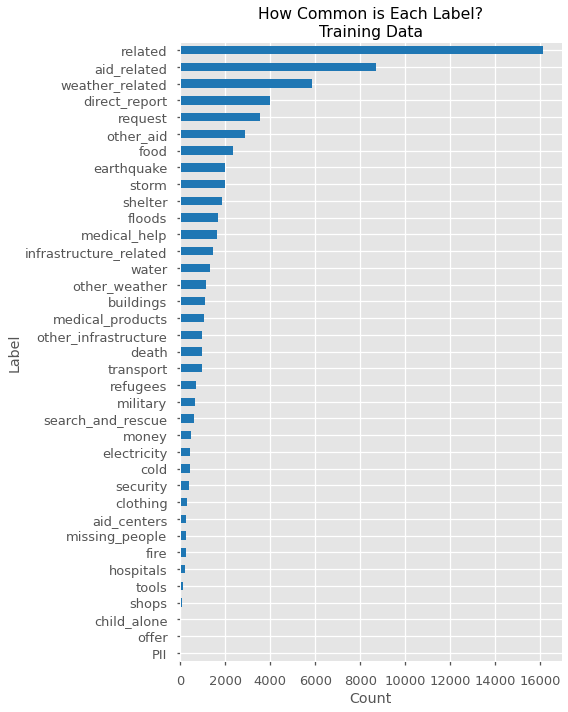

In [12]:
# Plot label-counts within the training data.
label_counts = dw.train[dw.target_columns].sum().sort_values()

fig, ax = plt.subplots(figsize=(8, 10))
label_counts.plot(kind='barh', color=COLORS['blue'])
ax.set(title='How Common is Each Label?\nTraining Data',
       ylabel='Label',
       xlabel='Count')
fig.tight_layout()

### Understand what the columns mean.

In [13]:
dw.column_descriptions

,Description
Column,
id,Unique ID for each individual row
split,"Test, tune, validation split"
message,English text of actual messages related to dis...
original,Text of column 3 in native language as origina...
genre,"Type of message, including direct messages, so..."
related,"Is the message disaster related? 1= yes, 2=no"
PII,"Does the message contain PII? 1= yes, 2=no"
request,"Does the message contain a request? 1= yes, 2=no"
offer,"Does the message contain an offer? 1= yes, 2=no"


- This is pretty predictable. The `message` column has text data (sometimes english translated). Each of the label columns is binary.
  - There is a typo in the label column descriptions: `{1: 'yes', 0: 'no'}`

### What kind of cleaning is required?
1. Drop columns `['id', 'split']`.
2. Examine the text for abnormalities.
3. Process the text data.
 1. Load in a pre-trained GloVe model. (https://nlp.stanford.edu/projects/glove/)
 2. Fit text on the GloVe model and homemade W2V model, trained on the text.

## Preparation
### Text Data

In [14]:
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 42)
Processed Val Data:
	(2573, 42)
Processed Test Data:
	(2629, 42)


#### Drop unnecessary columns.

In [15]:
dw.drop_column(['id', 'split'])

********************************************************************************
*                                   Success                                    *
********************************************************************************
Columns dropped:
	 ['id', 'split']

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(21046, 40)
Processed Val Data:
	(2573, 40)
Processed Test Data:
	(2629, 40)


#### Examine abnormalities and clean text.

In [16]:
# Clean HTML escape characters (such as ``&#39`` which maps to an apostrophe).
example_string = [string for string in dw.train['message']
                   if '&#' in string][0]
print(example_string)
print(html.unescape(example_string))

Most Eureka homeowners won&#39 t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT
Most Eureka homeowners won' t collect on quake insurance The California Earthquake Authority does not expec. http bit.ly 7RY2qT


In [17]:
dw.map_to_all('message', html.unescape)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Tokenize lower-case text.

In [18]:
# Set new column as copy to maintain original integrity.
for df in dw.processed_data:
    df['all_text_tokenized'] = df['message'].copy()

In [19]:
# Map all text to lower case.
dw.map_to_all('all_text_tokenized', lambda x: x.lower())

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [20]:
# Tokenize text into lists.
dw.map_to_all('all_text_tokenized', word_tokenize)

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Remove StopWords & Punctuation

In [21]:
# Stopwords list.
sw = corpus.stopwords.words('english')
sw += string.digits
sw += string.punctuation

not_in_sw = lambda x: [word for word in x if word not in sw]

# Remove stopwords and punctuation.
dw.map_to_all('all_text_tokenized', not_in_sw)

********************************************************************************
*                                   Success                                    *
********************************************************************************


In [22]:
dw.processed_train['all_text_tokenized'][0]

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']

#### Lemmatizer

In [23]:
# Create lemmatizer.
lemmatizer = WordNetLemmatizer()

In [24]:
# Change text to lemmatized version.
dw.map_to_all('all_text_tokenized', 
              lambda lst: [lemmatizer.lemmatize(word) for word in lst])

********************************************************************************
*                                   Success                                    *
********************************************************************************


#### Create total_vocabulary set.

In [25]:
# Set up total_vocabulary set with all unique words in all texts.
total_vocab = set(
    [word for entry in dw.processed_train[dw.predictive_columns].values 
     for word in entry]
)
print('Total unique words:', len(total_vocab))

Total unique words: 28780


#### Set DataWarehouse's column structure - x.

In [26]:
dw.predictive_columns = 'all_text_tokenized'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 ['related', 'PII', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


### Target Data

#### Set DataWarehouse's column structure - y.

In [27]:
dw.target_columns = 'aid_related'
dw.show_column_split()

********************************************************************************
*                                 Column Split                                 *
********************************************************************************
Predictive Columns (X):
	 all_text_tokenized

Target Columns (Y):
	 aid_related


In [28]:
TARGET_NAMES = ['Non-Aid-Related', 'Aid-Related']

********************************************************************************
*                           Aid-Related Value Counts                           *
********************************************************************************


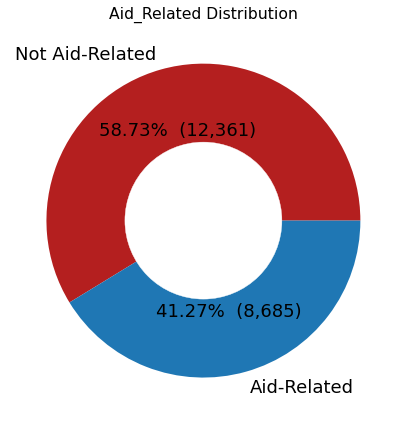

In [29]:
dw.plot_label_distribution('train', 
                           positive_color=COLORS['blue'],
                           negative_color=COLORS['red'],
                           negative_label='Not Aid-Related',
                           positive_label='Aid-Related',
                           title='Aid-Related Value Counts')

### Load Pretrained Vectorizer - GloVe

In [30]:
# Load in pretrained GloVe model.
glove = {}

with open('./models/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0].decode('utf-8')
        word_vector = np.array(line_split[1:], dtype=np.float32)
        glove[word] = word_vector
            
print('Total words loaded from GloVe:', len(glove))

Total words loaded from GloVe: 400000


In [31]:
# Test
glove['earthquake']

array([-0.093032 ,  1.6301   ,  0.36645  ,  0.29015  , -0.81781  ,
       -0.46611  ,  0.037282 ,  0.13208  ,  0.13661  ,  1.2091   ,
        0.81466  , -0.12874  ,  0.52387  , -0.024319 ,  0.94072  ,
       -0.12509  , -0.34087  ,  0.19321  , -1.0522   ,  0.62915  ,
       -0.0699   ,  0.14182  ,  0.49985  ,  0.61688  ,  0.027162 ,
        0.22695  , -0.89086  ,  1.4411   , -0.45774  , -0.5922   ,
        0.48147  , -0.4387   ,  0.99552  ,  1.3003   , -1.1123   ,
       -1.4847   ,  0.53476  , -0.22524  , -0.21366  , -0.14612  ,
       -0.50853  ,  0.82284  , -0.075167 , -0.60331  ,  0.86412  ,
        0.15815  ,  0.76075  , -0.28173  ,  0.27679  , -0.43729  ,
       -0.53438  ,  0.081051 ,  0.98763  , -0.28154  , -0.15944  ,
       -1.9562   ,  0.13058  , -0.46506  ,  1.4629   ,  1.262    ,
       -0.46154  ,  1.3625   , -0.40815  , -0.24256  ,  0.21117  ,
        0.57007  , -1.6566   , -0.21043  ,  0.97449  , -0.16146  ,
       -0.33706  ,  0.50539  ,  0.45718  ,  0.2184   ,  0.6955

### Create Word Vectorizer

In [32]:
# Train or load vectors.
if 'word2vec.wordvectors' not in os.listdir('./models/'):
    # Create model.
    word2vec = Word2Vec(dw.X_train(), 
                        size=100, 
                        window=5, 
                        min_count=5, 
                        workers=4,
                        seed=1)

    # Train model.
    word2vec.train(dw.X_train(), 
                   total_examples=word2vec.corpus_count, 
                   epochs=200)
    word_vectors = word2vec.wv

    # Save vectors.
    word_vectors.save('./models/word2vec.wordvectors')
    
else:
    # Load vectors.
    word_vectors = KeyedVectors.load('./models/word2vec.wordvectors', mmap='r')

In [33]:
# Test model - Most Similar.
for word in ['earthquake', 'help', 'village', 'water', 'people']:
    print(dis.headerize(word.upper()))
    print('Most Similar Words:')
    for i, similar in enumerate(
        [x[0] for x in word_vectors.most_similar(word)], 1):
        print(f'{i}.\t{similar}')
    print()
    print()

********************************************************************************
*                                  EARTHQUAKE                                  *
********************************************************************************
Most Similar Words:
1.	quake
2.	richter
3.	7.0
4.	aftershock
5.	haiti
6.	7.3
7.	bit.ly
8.	catastrophe
9.	temblor
10.	tinyurl.com


********************************************************************************
*                                     HELP                                     *
********************************************************************************
Most Similar Words:
1.	anything
2.	please
3.	u
4.	food
5.	need
6.	aid
7.	hungry
8.	thank
9.	something
10.	n't


********************************************************************************
*                                   VILLAGE                                    *
********************************************************************************
Most Similar Words:
1.	distr

In [34]:
# Test
word_vectors['earthquake']

array([ 0.3422797 , -0.4169431 , -0.487172  ,  0.59096515, -1.4398198 ,
       -0.07232627,  5.1914864 ,  1.0575953 ,  2.9493473 ,  2.8606458 ,
        0.94029933,  1.489159  , -0.12569374, -0.41890052,  0.0783684 ,
       -1.3229172 ,  1.1173074 , -1.9345144 ,  1.6816701 , -0.66852474,
        0.40670863, -0.6357084 ,  2.8612235 , -0.3080246 ,  1.6881121 ,
       -2.9619741 ,  3.0357738 , -0.75758636,  1.2253627 ,  1.758163  ,
       -0.5325943 ,  2.6076512 ,  2.0193367 ,  1.2376848 , -1.128269  ,
        1.2466476 ,  0.7226014 , -1.7695365 ,  0.20593132,  1.2718562 ,
       -2.5774963 , -2.8113346 , -1.168806  ,  2.2271252 , -3.3518178 ,
        1.5722014 , -0.2891352 , -0.03677477, -2.4971552 , -0.35060808,
        0.1683312 ,  0.9107666 ,  1.33695   , -1.6055559 , -1.5169129 ,
        2.0130653 ,  3.3567128 , -2.5407631 ,  2.1247141 ,  2.4240098 ,
        0.49031153, -2.1933057 ,  2.1280713 , -0.9948896 ,  0.47364694,
        2.7309027 , -2.0297077 , -1.6769437 , -1.4986056 , -2.03

## EDA

### Length of Messages.

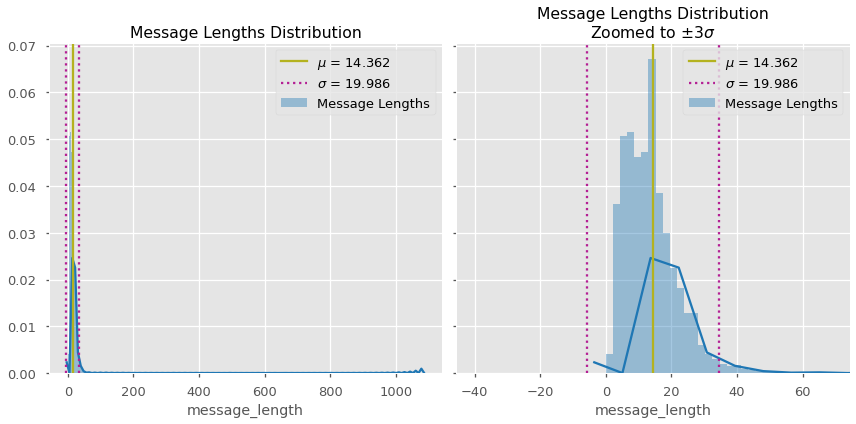

In [35]:
# Series of message lengths.
message_lengths = dw.processed_train[
    dw.predictive_columns].map(lambda x: len(x))
message_lengths.name = 'message_length'

dis.plot_message_lengths_distribution(message_lengths,
                                      dist_color=COLORS['blue'],
                                      mean_color=COLORS['yellow'],
                                      std_color=COLORS['purple'],
                                      pop_label='Message Lengths',
                                      bins=500)

In [36]:
# Examine extreme outliers in length.
message_lengths.sort_values(inplace=True)
longest_10 = message_lengths.tail(10)
shortest_10 = message_lengths.head(10)
print('Longest number of words:')
display(longest_10)
print('Shortest number of words:')
display(shortest_10)

print(dis.headerize('Longest'))
longest_entries = dw.processed_train[
    dw.predictive_columns].loc[longest_10.index].values
print(longest_entries[-1])

print(dis.headerize('Shortest'))
shortest_entries = dw.processed_train[
    dw.predictive_columns].loc[shortest_10.index].values
print(shortest_entries)

Longest number of words:


11828     419
12728     428
16676     466
16926     495
20012     496
13927     578
19916     637
15580     687
16741    1083
12890    1083
Name: message_length, dtype: int64

Shortest number of words:


9819    0
7778    1
7761    1
4944    1
7414    1
9857    1
5474    1
9827    1
5462    1
9740    1
Name: message_length, dtype: int64

********************************************************************************
*                                   Longest                                    *
********************************************************************************


['weather', 'forecast', 'indicates', 'rain', 'go', 'least', 'late', 'december', 'severe', 'drought', 'parching', 'east', 'africa', 'left', '10', 'million', 'facing', 'hunger', 'scope', 'one', 'world', "'s", 'worst', 'unfolding', 'humanitarian', 'disaster', 'conjured', 'memory', 'ethiopia', "'s", 'devastating', '1984', 'famine', 'seismologist', 'agree', 'padang', 'face', 'earthquake', 'future', 'warn', 'much', 'larger', 'quake', 'far', 'greater', 'destructive', 'force', 'inevitable', 'region', 'flash', 'flood', 'followed', 'torrential', 'monsoonal', 'rain', 'north-west', 'pakistan', '28', '30', 'july', 'caused', 'great', 'loss', 'life', 'wide-spread', 'damage', 'infrastructure', 'livestock', 'property', '100', 'village', 'lesotho', 'swaziland', 'would', 'also', 'experience', 'scattered', 'rain', 'noted', 'floodwaters', 'subsided', 'area', 'fresh', 'flooding', 'north', 'state', 'heavy', 'rainfall', 'forecast', 'elsewhere', 'approximately', '1.9', 'million', 'people', 'affected', 'past', 

********************************************************************************
*                                   Shortest                                   *
********************************************************************************
[list([]) list(['sonami']) list(['spot']) list(['see'])
 list(['earthquake']) list(['mutaser']) list(['earthquake'])
 list(['thatta']) list(['paklascencion']) list(['name'])]


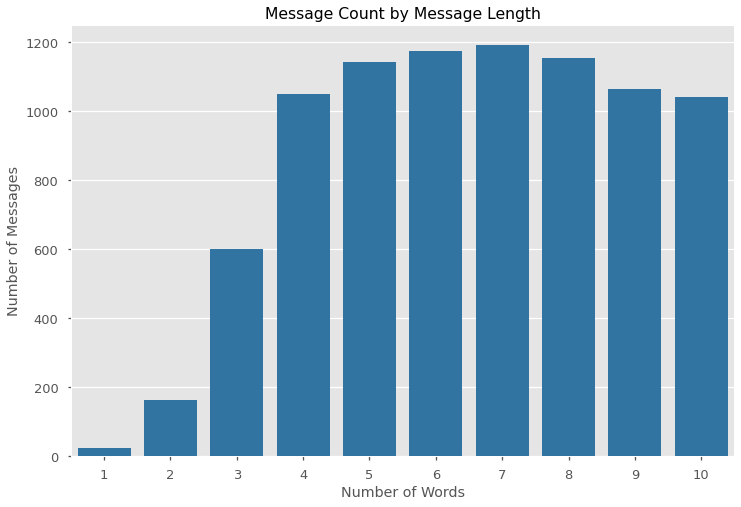

In [37]:
# Plot how many messages contain 10 or fewer words.
x = list(range(1, 10+1))
y = []
for i in x:
    y.append((message_lengths == i).sum())
fig, ax = plt.subplots()
sns.barplot(x=x, y=y, color=COLORS['blue'], ax=ax)
ax.set(title='Message Count by Message Length',
       xlabel='Number of Words',
       ylabel='Number of Messages')
fig.tight_layout()

In [38]:
# Drop messages with fewer than 4 words.
for df in dw.processed_data:
    lengths = df[dw.predictive_columns].map(lambda x: len(x))
    if lengths.index[0] in df.index:
        df.drop(lengths[lengths < 4].index, inplace=True)
        
dw.show_data_shapes()

********************************************************************************
*                                 Data Shapes                                  *
********************************************************************************
Processed Training Data:
	(20260, 41)
Processed Val Data:
	(2462, 41)
Processed Test Data:
	(2535, 41)


### Percentage of recognized words. 

Number of recognized words: 224624
Number of words:            300112
Percent:                    0.7484672388974782


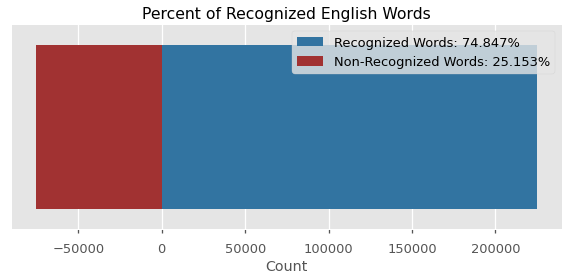

In [39]:
def percent_english(array, verbose=True):
    all_words = set(corpus.words.words())
    num_words = 0
    num_english = 0
    for tokenized_lst in array:
        for word in tokenized_lst:
            num_words += 1
            if word in all_words:
                num_english += 1
    print('Number of recognized words:', num_english)
    print('Number of words:           ', num_words)
    print('Percent:                   ', num_english/num_words)
    return num_english, num_words
    
    
num_recognized, num_words = percent_english(dw.X_train())
num_not_recognized = num_words - num_recognized
pct_rec = num_recognized / num_words
pct_not_rec = num_not_recognized / num_words

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=[num_recognized], y=[0], 
            orient='h', 
            ax=ax, 
            color=COLORS['blue'], 
            label=f'Recognized Words: {round(pct_rec*100, 3)}%')
sns.barplot(x=[-num_not_recognized], y=[0], 
            orient='h', 
            ax=ax, 
            color=COLORS['red'], 
            label=f'Non-Recognized Words: {round(pct_not_rec*100, 3)}%')
ax.legend()
ax.set_yticks([])
ax.set(title='Percent of Recognized English Words',
       xlabel='Count')
fig.tight_layout()

### Word Frequencies / WordCloud

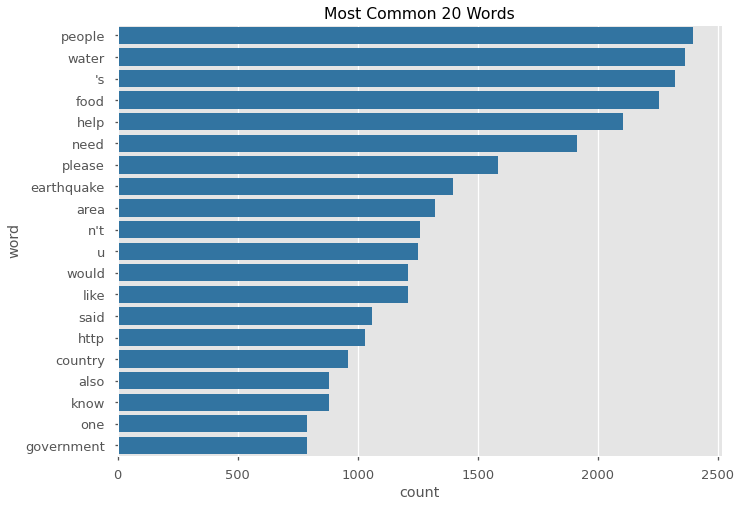

In [40]:
# Plot top 20 words.
all_words = [w for entry in dw.processed_train['all_text_tokenized'].values 
             for w in entry]

freqdist = FreqDist(all_words)
top = pd.DataFrame(freqdist.most_common(20), columns=['word', 'count'])
fig, ax = plt.subplots()
sns.barplot(x='count', y='word', data=top, orient='h', color=COLORS['blue'])
ax.set(title='Most Common 20 Words')
fig.tight_layout()

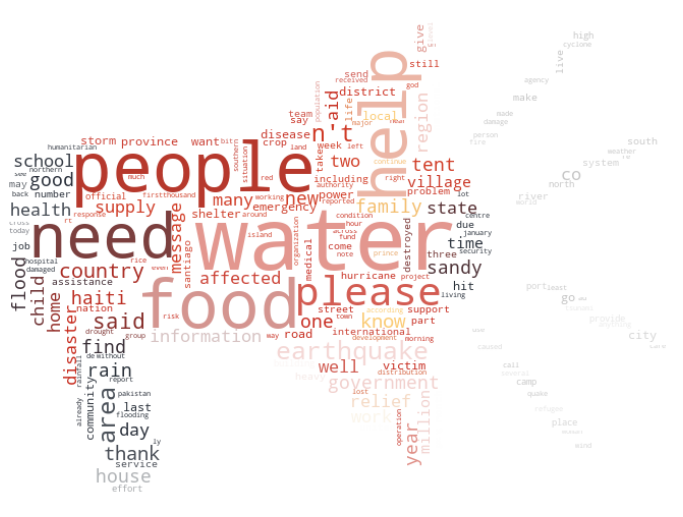

In [41]:
# Image mask.
message_mask = np.array(Image.open('./images/emergency.png'))

# Create wordcloud.
wordcloud = WordCloud(random_state=51, 
                      background_color='white',
                      mode='RGBA',
                      mask=message_mask,
                      collocations=False).generate(' '.join(all_words))
image_colors = ImageColorGenerator(message_mask)

# Show.
dis.plot_wordcloud(wordcloud.recolor(color_func=image_colors), figsize=(12,12))

### What are the most common words for each label?

In [42]:
# Create dictionary for each column.
top_words = {}
for n in (0, 1):
    col_vocab = [
        word for entry in dw.processed_train[
            dw.processed_train[dw.target_columns] == n
        ]['all_text_tokenized'].values
        for word in entry if word not in sw
    ]
    top_words[f'{dw.target_columns}_{str(n)}'] = dict(text=' '.join(col_vocab))
top_words.keys()

dict_keys(['aid_related_0', 'aid_related_1'])

*********************************************
*               AID_RELATED_0               *
*********************************************


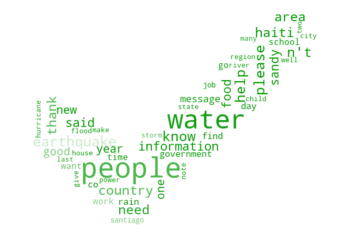

*********************************************
*               AID_RELATED_1               *
*********************************************


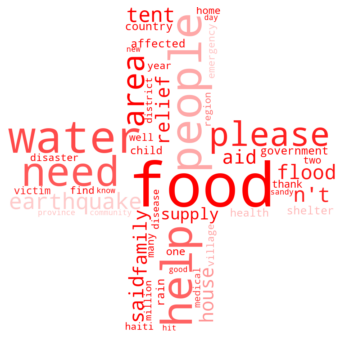

In [43]:
# Set masks.
top_words['aid_related_0']['mask'] = np.array(
    Image.open('./images/check.png'))
top_words['aid_related_1']['mask'] = np.array(
    Image.open('./images/red_cross.png'))

# Create wordclouds and colors.
for label in top_words:
    wc = WordCloud(
        max_words=50,
        random_state=51, 
        background_color='white', 
        mode='RGBA',
        mask=top_words[label]['mask'],
        collocations=False).generate(top_words[label]['text'])
    im_colors = ImageColorGenerator(top_words[label]['mask'])
    
    # Plot wordclouds.
    print(dis.headerize(label.upper(), max_len=45))
    dis.plot_wordcloud(wc.recolor(color_func=im_colors), figsize=(6,6))

### Phrases - Ngrams

********************************************************************************
*                             Most Common Phrases                              *
********************************************************************************


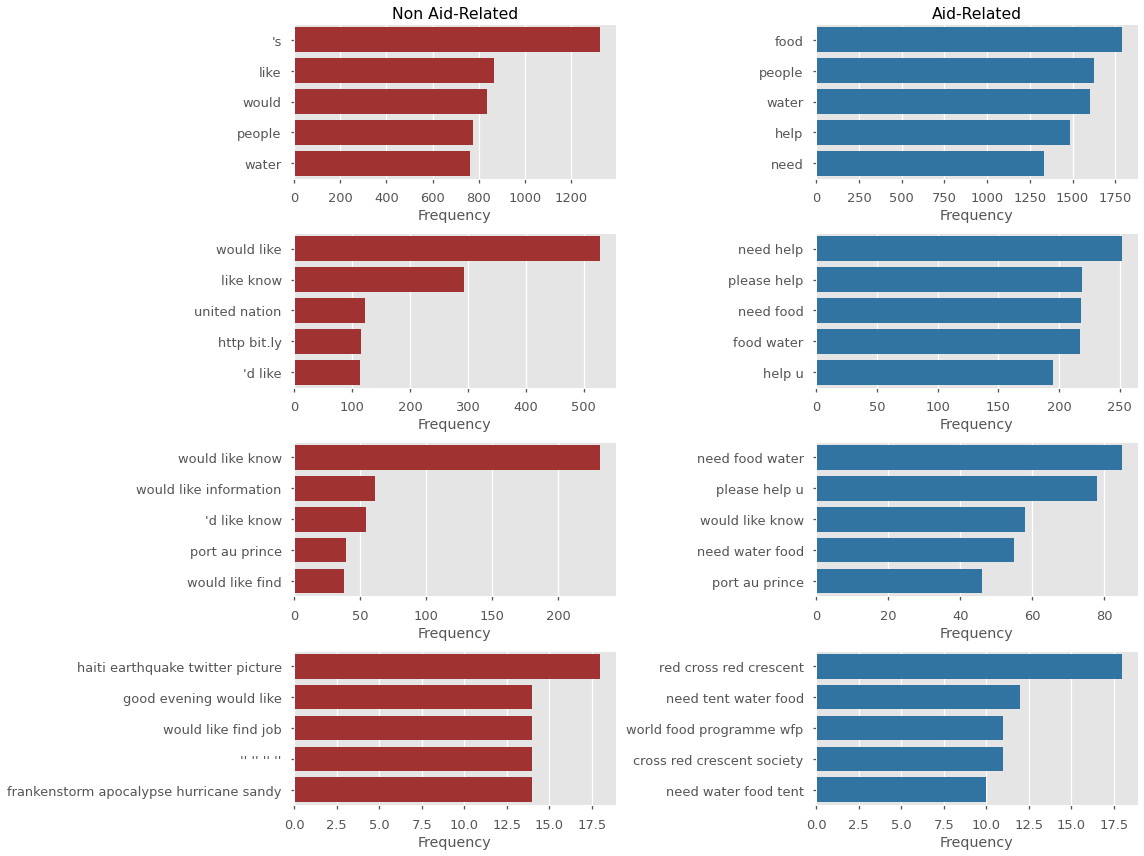

In [44]:
# Get positive and negative labels.
neg = dw.processed_train[
    dw.processed_train[dw.target_columns] == 0][dw.predictive_columns].values
pos = dw.processed_train[
    dw.processed_train[dw.target_columns] == 1][dw.predictive_columns].values

# Plot ngrams.
dis.plot_top_ngrams(4, 
                    pos, neg, 
                    COLORS['blue'], COLORS['red'], 
                    'Aid-Related', 'Non Aid-Related',
                    'Most Common Phrases')

### Word Types - Spacy

In [45]:
# spacey_load = spacy.load('en_core_web_sm')

In [46]:
# # Example.
# print(dis.headerize('Spacy Example'))

# text = dw.processed_train['all_text'][0]
# print(text)

# # Read in text & render 'entitys'.
# ex_spacy = spacey_load(text)
# spacy.displacy.render(ex_spacy, style='ent')

In [47]:
# # Work with a sample of the training data.
# ents_lst = []
# sample = dw.processed_train['all_text'][:5_000]
# total = len(sample)

# # Get total entities found.
# for i, entry in enumerate(sample, 1):
#     if i % 200 == 0:
#         clear_output(wait=True)
#         print(dis.headerize(f'Working: {i} / {total}'))
#     spacey_doc = spacey_load(entry)
#     ents_lst += [x.label_ for x in spacey_doc.ents]

In [48]:
# # Plot top entities from training sample.
# top_10_ents = FreqDist(ents_lst).most_common(10)

# x = []
# y = []
# for ent, count in top_10_ents:
#     x.append(count)
#     y.append(ent)

# fig, ax = plt.subplots()
# sns.barplot(x=x, y=y, color=COLORS['blue'], orient='h')
# ax.set(title='Most Common Word Entities',
#        xlabel='Count',
#        ylabel='Word Entity')
# fig.tight_layout()

# Modeling

There are two different data processing methods which will be modeled with. The models' metrics will then be compared and a final model will be selected.

The processing methods are:
- **Mean Word Embeddings**
 - There are two types of embedders we will be using - pretrained **GloVe** (Global Vectors for Word Representation - https://nlp.stanford.edu/projects/glove/) and homemade **Word2Vec** (a vectorizer trained only on the training data).
 - For each message, every word has an n-dimension representation in vector space (in our case, 100-dimension). 
   - For words that don't exist in the *GloVe* model, they are represented as a vector of zeros.
 - The mean of each sentence's words is calculated and a single n-dimensional vector is used to represent the entire message.
- **Tokenization**
 - This is used in Recurrent Neural Networks to utilize the skill of using *ordered sequences* as they exist.
 - These models use an array representation of each word in a message (with a pretrained weights system - GloVe in this case).
 - The word-representations are learned sequentially and meanings are extrapolated from the order they appear, rather than as a conglomerate.

In [49]:
# Create MeanEmbedders
mean_embedder_GLOVE = dis.MeanEmbedder(glove, verbose=True)
mean_embedder_W2V = dis.MeanEmbedder(word_vectors, verbose=True)

Loaded from dictionary.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100
Loaded from W2V.
********************************************************************************
*                                   Success                                    *
********************************************************************************
Embedding model loaded. Dimensions: 100


## ML - SKLearn

#### Classifier Functions

In [50]:
def create_rfc_step_params():
    # RFC pipeline.
    rfc = RandomForestClassifier(n_estimators=100, 
                                 class_weight='balanced', 
                                 random_state=51)
    rfc_step = ('RFC', rfc)

    # RFC GridSearch.
    rfc_params = {
        'RFC__criterion': ['gini', 'entropy'],
        'RFC__min_samples_split': [2, 5, 0.01, 0.05],
        'RFC__max_features': ['sqrt', 'log2', None]
    }
    return (rfc_step, rfc_params)

In [51]:
def create_svc_step_params():
    # SVC pipeline.
    svc = SVC(class_weight='balanced', 
              random_state=51)
    svc_step = ('SVC', svc)

    # SVC GridSearch.
    svc_params = {
        'SVC__C': [0.1, 1., 10.],
        'SVC__kernel': ['poly', 'rbf', 'sigmoid'],
        'SVC__gamma': [0.1, 0.5, 1.]
    }
    return (svc_step, svc_params)

In [52]:
def create_logreg_step_params():
    # LogReg pipeline.
    logreg = LogisticRegression(class_weight='balanced',
                                random_state=51)
    logreg_step = ('LOGREG', logreg)

    logreg_params = {
        'LOGREG__C': [0.1, 1., 10.],
        'LOGREG__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
    return (logreg_step, logreg_params)

In [53]:
def make_classifiers_lst():
    return [
        create_rfc_step_params(),
        create_svc_step_params(),
        create_logreg_step_params()
    ]

### MeanWordEmbedder - GloVe

#### Naive Bayes

********************************************************************************
*                             Naive Bayes - GloVe                              *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.786318  0.649233   0.71123     1434
Aid-Related       0.606416  0.753891   0.67216     1028

   accuracy
   0.692933

              precision    recall  f1-score  support
macro avg      0.696367  0.701562  0.691695     2462
weighted avg   0.711200  0.692933  0.694916     2462


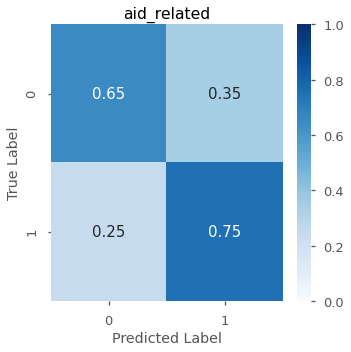

,NB_glove
F1,0.687399
Accuracy,0.694675
Recall,0.748461
Precision,0.635549


In [54]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_GLOVE),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - GloVe',
                      target_names=TARGET_NAMES,
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_glove', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [55]:
SKLEARN_DIR = './models/sklearn/'

In [56]:
FIT_GLOVE_GRIDSEARCH = False

In [57]:
GLOVE_SUFFIX = '_glove'

if FIT_GLOVE_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_glove_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_GLOVE, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=GLOVE_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{GLOVE_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_glove_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{GLOVE_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_GLOVE_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_SKLEARN_MODELS` to True''')

********************************************************************************
*                                 RFC - GloVe                                  *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.788341  0.792190  0.790261     1434
Aid-Related       0.708129  0.703307  0.705710     1028

   accuracy
   0.755077

              precision    recall  f1-score  support
macro avg      0.748235  0.747749  0.747985     2462
weighted avg   0.754849  0.755077  0.754957     2462


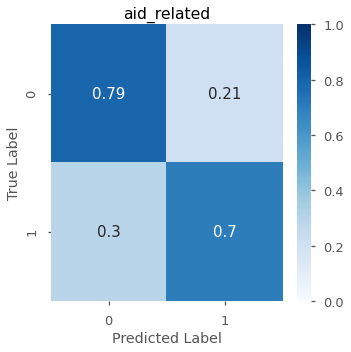

********************************************************************************
*                                 SVC - GloVe                                  *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.830289  0.760809  0.794032     1434
Aid-Related       0.701220  0.783074  0.739890     1028

   accuracy
   0.770106

              precision    recall  f1-score  support
macro avg      0.765754  0.771941  0.766961     2462
weighted avg   0.776397  0.770106  0.771425     2462


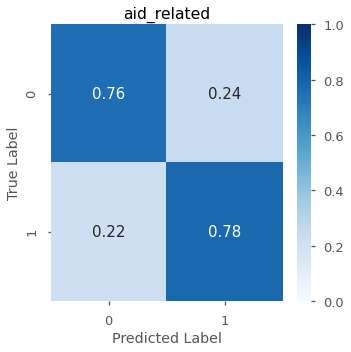

********************************************************************************
*                                LOGREG - GloVe                                *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.860302  0.596932  0.704817     1434
Aid-Related       0.605999  0.864786  0.712625     1028

   accuracy
   0.708773

              precision    recall  f1-score  support
macro avg      0.733150  0.730859  0.708721     2462
weighted avg   0.754118  0.708773  0.708077     2462


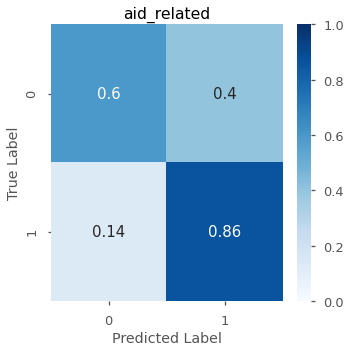

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove
F1,0.687399,0.729583,0.770085,0.732658
Accuracy,0.694675,0.764892,0.787771,0.718738
Recall,0.748461,0.707124,0.792436,0.859279
Precision,0.635549,0.753515,0.748961,0.638562


In [58]:
# Show model scores.
for name, clf in best_glove_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    header=f'{name} - GloVe',
                    target_names=TARGET_NAMES,
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_glove', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

### MeanWordEmbedder - Homemade Word Vectorizer

#### Naive Bayes

********************************************************************************
*                            Naive Bayes - Word2Vec                            *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.799153  0.657601  0.721500     1434
Aid-Related       0.617005  0.769455  0.684848     1028

   accuracy
   0.704305

              precision    recall  f1-score  support
macro avg      0.708079  0.713528  0.703174     2462
weighted avg   0.723097  0.704305  0.706196     2462


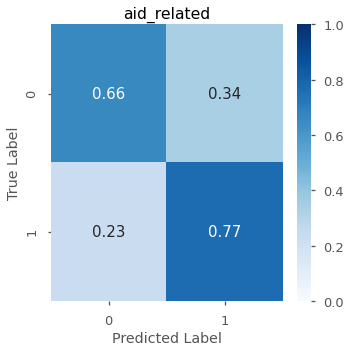

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v
F1,0.687399,0.729583,0.770085,0.732658,0.722200
Accuracy,0.694675,0.764892,0.787771,0.718738,0.728994
Recall,0.748461,0.707124,0.792436,0.859279,0.785400
Precision,0.635549,0.753515,0.748961,0.638562,0.668413


In [59]:
# Set up NB Pipeline.
nb = GaussianNB()

ovr_pipe = Pipeline([
    ('MeanWordEmbedder', mean_embedder_W2V),
    ('OVR_Logistic_Regression', nb)
])

# Fit / predict.
dis.fit_predict_model(clf=ovr_pipe,
                      X_train=dw.X_train(), 
                      Y_train=dw.Y_train(),
                      X_val=dw.X_val(),
                      Y_val=dw.Y_val(),
                      header='Naive Bayes - Word2Vec',
                      target_names=TARGET_NAMES,
                      target_column_names=dw.target_columns,
                      plot_confusion=True)

results_df = assign_scores(
    df=results_df, 
    column_name='NB_w2v', 
    scores=dis.get_scores(dw.Y_test(), ovr_pipe.predict(dw.X_test())))
results_df

#### GridSearch

In [60]:
FIT_W2V_GRIDSEARCH = False

In [61]:
W2V_SUFFIX = '_w2v'

if FIT_W2V_GRIDSEARCH:
    # Run GridSearch on above model specifications.
    best_w2v_estimators_lst = dis.gridsearch_classifiers(
        classifiers=make_classifiers_lst(), 
        mean_word_embedder=mean_embedder_W2V, 
        directory=SKLEARN_DIR, 
        X_train=dw.X_train(), 
        Y_train=dw.Y_train(), 
        suffix_label=W2V_SUFFIX)
    
# If the files are in the directory.
elif any(
    [f.endswith(f'{W2V_SUFFIX}.pkl') for f in os.listdir(SKLEARN_DIR)]
    ):
    # Load in models.
    best_w2v_estimators_lst = [
        (name, joblib.load(f'{SKLEARN_DIR}{name}{W2V_SUFFIX}.pkl')) 
        for (name, clf), _ in make_classifiers_lst()
    ]

# The models could not be found and `FIT_W2V_GRIDSEARCH` is False.
else:
    raise Exception(f'''Models not found in {SKLEARN_DIR}. 
Put the files in the directory or set `FIT_W2V_GRIDSEARCH` to True''')

********************************************************************************
*                                  RFC - W2V                                   *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.763087  0.792887  0.777702     1434
Aid-Related       0.694444  0.656615  0.675000     1028

   accuracy
   0.735987

              precision    recall  f1-score  support
macro avg      0.728766  0.724751  0.726351     2462
weighted avg   0.734426  0.735987  0.734819     2462


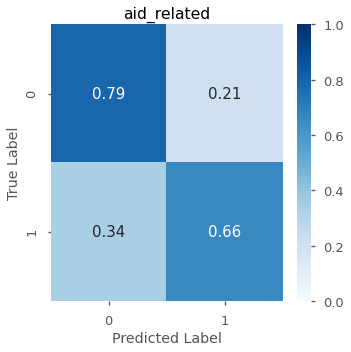

********************************************************************************
*                                  SVC - W2V                                   *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related   0.835938  0.671548  0.744780     1434
Aid-Related       0.640458  0.816148  0.717707     1028

   accuracy
   0.731925

              precision    recall  f1-score  support
macro avg      0.738198  0.743848  0.731244     2462
weighted avg   0.754316  0.731925  0.733476     2462


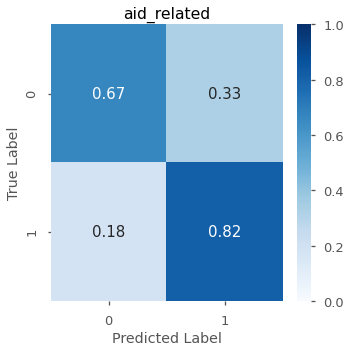

********************************************************************************
*                                 LOGREG - W2V                                 *
********************************************************************************
                 precision    recall  f1-score  support
Non-Aid-Related    0.86800  0.453975  0.596154     1434
Aid-Related        0.54264  0.903696  0.678102     1028

   accuracy
   0.641755

              precision    recall  f1-score  support
macro avg      0.705320  0.678836  0.637128     2462
weighted avg   0.732147  0.641755  0.630371     2462


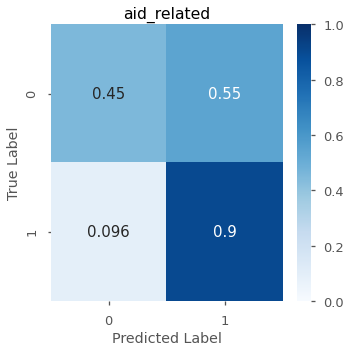

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v
F1,0.687399,0.729583,0.770085,0.732658,0.722200,0.712071,0.756329,0.710856
Accuracy,0.694675,0.764892,0.787771,0.718738,0.728994,0.758185,0.757002,0.662722
Recall,0.748461,0.707124,0.792436,0.859279,0.785400,0.666667,0.840809,0.924362
Precision,0.635549,0.753515,0.748961,0.638562,0.668413,0.764113,0.687275,0.577473


In [62]:
# Show model scores.
for name, clf in best_w2v_estimators_lst:
    dis.show_scores(y_true=dw.Y_val(), 
                    y_pred=clf.predict(dw.X_val()),
                    conf_matrix=True,
                    target_names=TARGET_NAMES,
                    header=f'{name} - W2V',
                    column_names=dw.target_columns)
    
    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}{W2V_SUFFIX}', 
        scores=dis.get_scores(dw.Y_test(), clf.predict(dw.X_test())))

results_df

## TensorFlow Neural Network

### NN Functions

In [63]:
def build_simple_nn():
    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [64]:
def build_multilayer_nn(dense_layers=10):
    # Each layer should have more nodes than the following node.
    # I want the final layer to have 2 nodes.
    node_sizes = [2]
    for _ in range(dense_layers-1):
        node_sizes.append(int(node_sizes[-1] + (node_sizes[-1] * 0.75)))
    print(dis.headerize(f'Nodes Per Layer: {node_sizes[::-1]}'))
    
    model = models.Sequential()
    for n in node_sizes[::-1]:
        model.add(layers.Dense(n, activation='relu'))
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

```python
>>> # `build_multilayer_nn` function example:
>>> for d in range(1, 7):
...     node_sizes = [2]
...     for _ in range(d-1):
...         node_sizes.append(int(node_sizes[-1] + (node_sizes[-1] * 0.75)))
...     print(node_sizes[::-1])
[2]
[3, 2]
[5, 3, 2]
[8, 5, 3, 2]
[14, 8, 5, 3, 2]
[24, 14, 8, 5, 3, 2]
```

In [65]:
# Metrics
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [66]:
# Create weights dict for slight class imbalance.
WEIGHTS_DCT = {
    k: v for k, v in set(
        zip(dw.Y_train(), compute_sample_weight('balanced', dw.Y_train()))
        )
}
WEIGHTS_DCT

{0: 0.8649987191529331, 1: 1.184933910398877}

### MeanWordEmbedder - GloVe

In [67]:
TRAIN_GLOVE_NN = False

##### Processing

In [68]:
# Transform GloVe data.
X_train_glove = mean_embedder_GLOVE.transform(dw.X_train())
X_val_glove = mean_embedder_GLOVE.transform(dw.X_val())
X_test_glove = mean_embedder_GLOVE.transform(dw.X_test())

X_train_glove.shape, X_val_glove.shape, X_test_glove.shape

((20260, 100), (2462, 100), (2535, 100))

##### Modeling

In [69]:
# Create models.
simple_glove_model = build_simple_nn()
multilayer_glove_model = build_multilayer_nn(6)

for model in (simple_glove_model, multilayer_glove_model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [70]:
simple_glove_path = './models/tensorflow/simple_glove_model.h5'
multilayer_glove_path = './models/tensorflow/multilayer_glove_model.h5'
simple_glove_dir = os.path.dirname(simple_glove_path)
multilayer_glove_dir = os.path.dirname(multilayer_glove_path)

# Train models with mean word embeddings and GloVe vectors.
if TRAIN_GLOVE_NN:
    simple_glove_history = dis.train_dump_model(
        name='simple_glove_model', 
        model=simple_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=simple_glove_path
        )
    multilayer_glove_history = dis.train_dump_model(
        name='multilayer_glove_model', 
        model=multilayer_glove_model, 
        X_train=X_train_glove, 
        y_train=dw.Y_train(), 
        X_val=X_val_glove, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=multilayer_glove_path
        )

# Load pretrained models.
else:
    simple_glove_model = load_model(simple_glove_path)
    multilayer_glove_model = load_model(multilayer_glove_path)
    
    simple_glove_history = joblib.load(
        simple_glove_dir+'/simple_glove_model_history.pkl')
    multilayer_glove_history = joblib.load(
        multilayer_glove_dir+'/multilayer_glove_model_history.pkl')

********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************


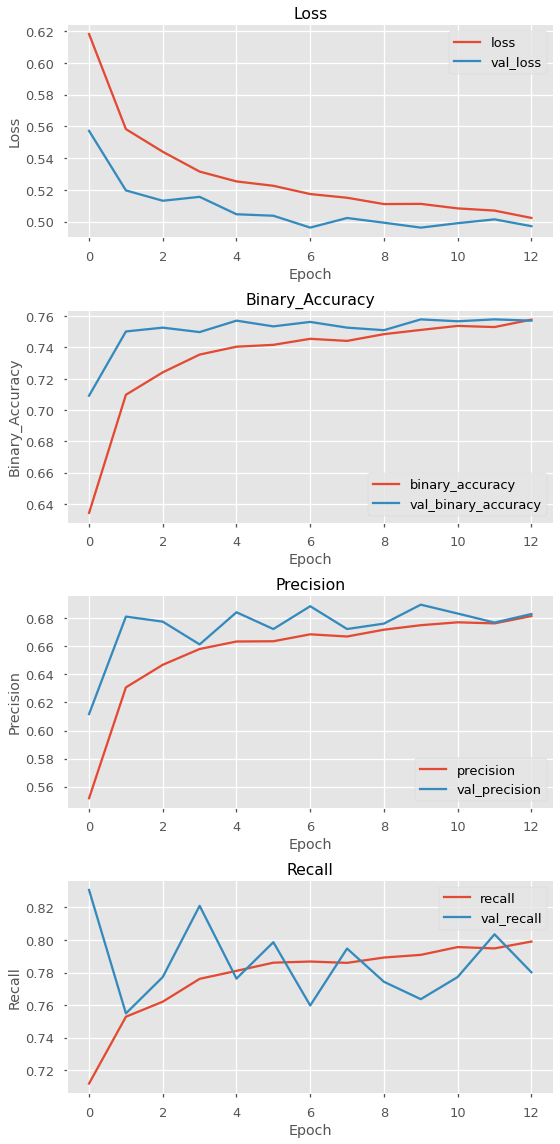

********************************************************************************
*                       simple_model - NN - MWE - GloVe                        *
********************************************************************************
   precision    recall  f1-score  support
0   0.824534  0.740586  0.780309     1434
1   0.683135  0.780156  0.728429     1028

   accuracy
   0.757108

              precision    recall  f1-score  support
macro avg      0.753834  0.760371  0.754369     2462
weighted avg   0.765493  0.757108  0.758646     2462


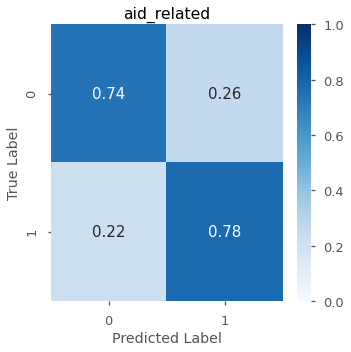

********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************


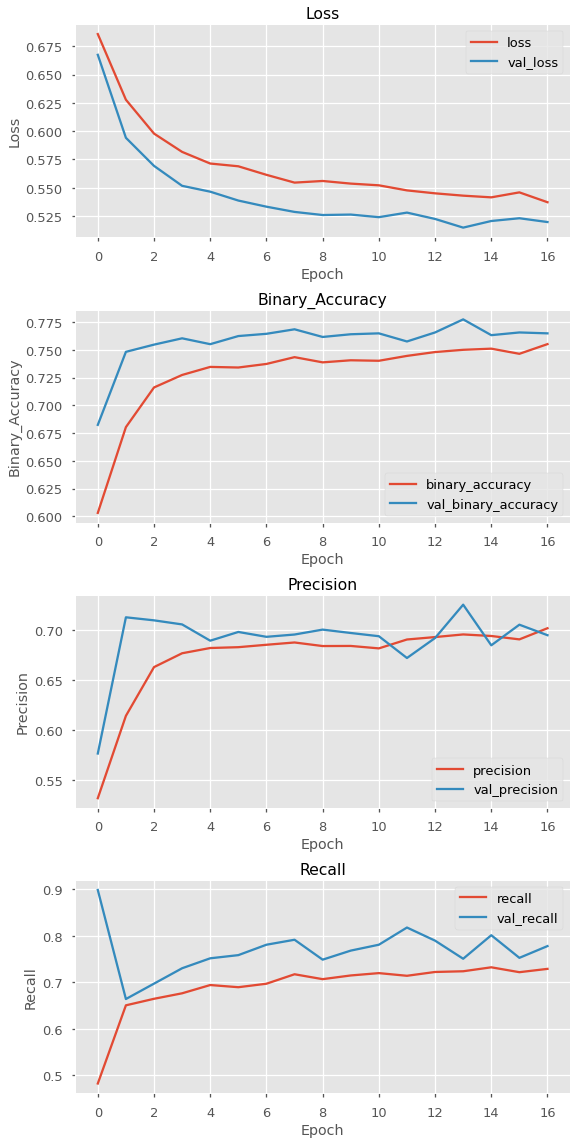

********************************************************************************
*                     multilayer_model - NN - MWE - GloVe                      *
********************************************************************************
   precision   recall  f1-score  support
0   0.826087  0.75523  0.789071     1434
1   0.695048  0.77821  0.734282     1028

   accuracy
   0.764825

              precision    recall  f1-score  support
macro avg      0.760567  0.766720  0.761676     2462
weighted avg   0.771372  0.764825  0.766194     2462


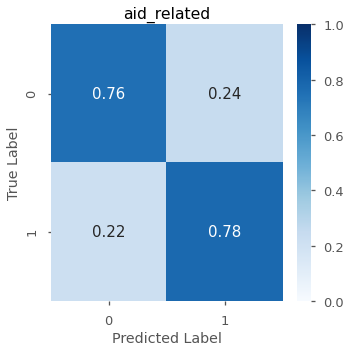

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove
F1,0.687399,0.729583,0.770085,0.732658,0.722200,0.712071,0.756329,0.710856,0.754290,0.756849
Accuracy,0.694675,0.764892,0.787771,0.718738,0.728994,0.758185,0.757002,0.662722,0.768442,0.775937
Recall,0.748461,0.707124,0.792436,0.859279,0.785400,0.666667,0.840809,0.924362,0.792436,0.777485
Precision,0.635549,0.753515,0.748961,0.638562,0.668413,0.764113,0.687275,0.577473,0.719649,0.737281


In [71]:
# Evaluate all mean-embedded GloVe models.
glove_nn_lst = [
    ('simple_model', simple_glove_model, simple_glove_history),
    ('multilayer_model', multilayer_glove_model, multilayer_glove_history)
]

for name, model, history in glove_nn_lst:
    y_test_pred = dis.evaluate_nn(model, 
                                  history, 
                                  X_val_glove, 
                                  dw.Y_val(), 
                                  X_test_glove, 
                                  header=f'{name} - NN - MWE - GloVe', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_glove', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### MeanWordEmbedder - Homemade Word Vectorizer

In [72]:
TRAIN_W2V_NN = False

##### Processing

In [73]:
# Set up data.
X_train_w2v = mean_embedder_W2V.transform(dw.X_train())
X_val_w2v = mean_embedder_W2V.transform(dw.X_val())
X_test_w2v = mean_embedder_W2V.transform(dw.X_test())

X_train_w2v.shape, X_val_w2v.shape, X_test_w2v.shape

((20260, 100), (2462, 100), (2535, 100))

##### Modeling

In [74]:
# Create models.
simple_w2v_model = build_simple_nn()
multilayer_w2v_model = build_multilayer_nn(6)

for model in (simple_w2v_model, multilayer_w2v_model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)

********************************************************************************
*                    Nodes Per Layer: [24, 14, 8, 5, 3, 2]                     *
********************************************************************************


In [75]:
simple_w2v_path = './models/tensorflow/simple_w2v_model.h5'
multilayer_w2v_path = './models/tensorflow/multilayer_w2v_model.h5'
simple_w2v_dir = os.path.dirname(simple_w2v_path)
multilayer_w2v_dir = os.path.dirname(multilayer_w2v_path)

# Train models with mean word embeddings and homemade vectors. 
if TRAIN_W2V_NN:
    simple_w2v_history = dis.train_dump_model(
        name='simple_w2v_model', 
        model=simple_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=simple_w2v_path
        )
    multilayer_w2v_history = dis.train_dump_model(
        name='multilayer_w2v_model', 
        model=multilayer_w2v_model, 
        X_train=X_train_w2v, 
        y_train=dw.Y_train(), 
        X_val=X_val_w2v, 
        y_val=dw.Y_val(), 
        class_weight=WEIGHTS_DCT,
        f_path=multilayer_w2v_path
        )
    
# Load pretrained models.
else:
    simple_w2v_model = load_model(simple_w2v_path)
    multilayer_w2v_model = load_model(multilayer_w2v_path)
    
    simple_w2v_history = joblib.load(
        simple_w2v_dir+'/simple_w2v_model_history.pkl')
    multilayer_w2v_history = joblib.load(
        multilayer_w2v_dir+'/multilayer_w2v_model_history.pkl')

********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************


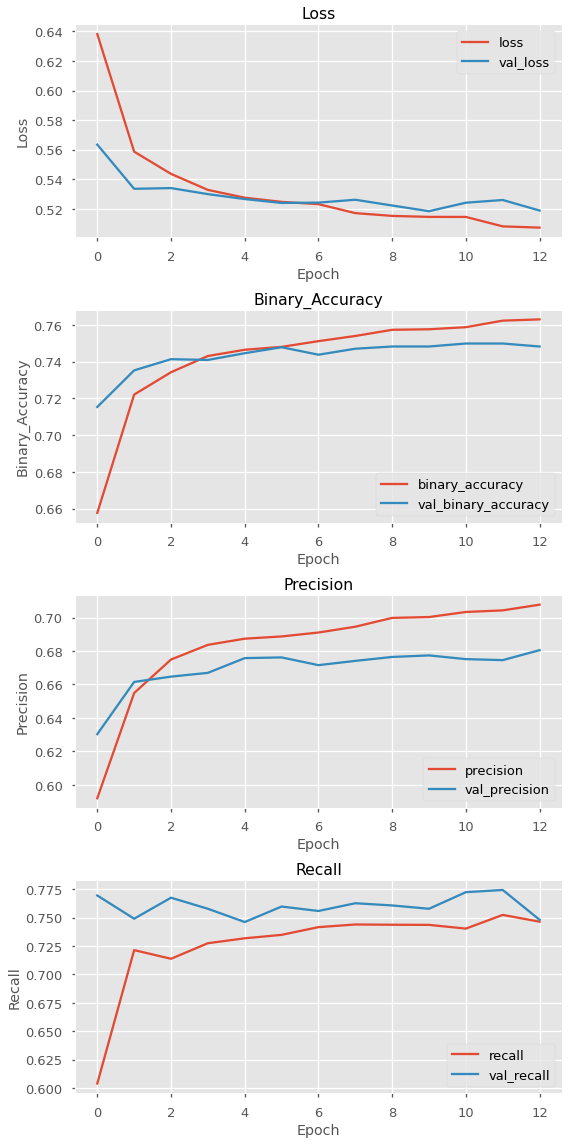

********************************************************************************
*                        simple_model - NN - MWE - W2V                         *
********************************************************************************
   precision    recall  f1-score  support
0   0.805556  0.748257  0.775850     1434
1   0.680531  0.748054  0.712697     1028

   accuracy
   0.748172

              precision    recall  f1-score  support
macro avg      0.743043  0.748156  0.744273     2462
weighted avg   0.753352  0.748172  0.749480     2462


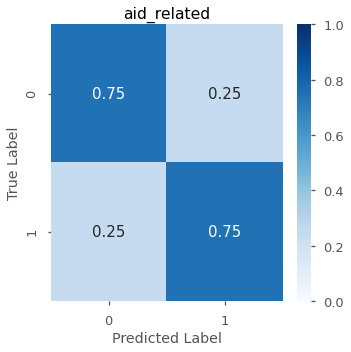

********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************


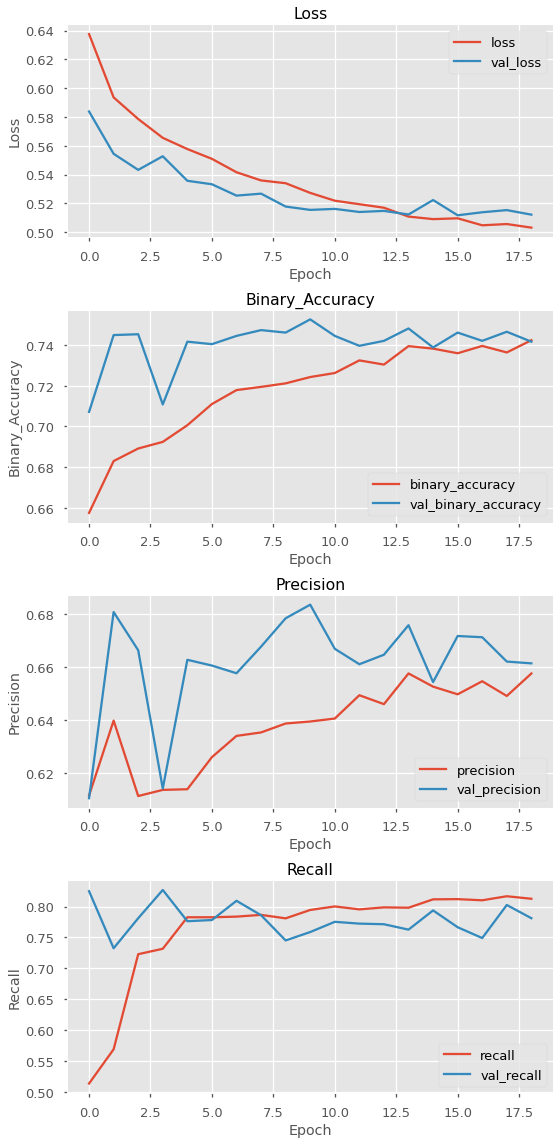

********************************************************************************
*                      multilayer_model - NN - MWE - W2V                       *
********************************************************************************
   precision    recall  f1-score  support
0   0.819712  0.713389  0.762864     1434
1   0.661450  0.781128  0.716325     1028

   accuracy
   0.741673

              precision    recall  f1-score  support
macro avg      0.740581  0.747259  0.739594     2462
weighted avg   0.753630  0.741673  0.743431     2462


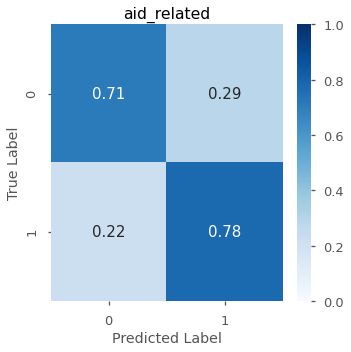

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v
F1,0.687399,0.729583,0.770085,0.732658,0.722200,0.712071,0.756329,0.710856,0.754290,0.756849,0.752707,0.768911
Accuracy,0.694675,0.764892,0.787771,0.718738,0.728994,0.758185,0.757002,0.662722,0.768442,0.775937,0.774753,0.780671
Recall,0.748461,0.707124,0.792436,0.859279,0.785400,0.666667,0.840809,0.924362,0.792436,0.777485,0.764292,0.813544
Precision,0.635549,0.753515,0.748961,0.638562,0.668413,0.764113,0.687275,0.577473,0.719649,0.737281,0.741468,0.728920


In [76]:
# Evaluate mean-embedded W2V models.
w2v_nn_dct = {
    'simple_model': {
        'model': simple_w2v_model,
        'history': simple_w2v_history
    },
    'multilayer_model': {
        'model': multilayer_w2v_model,
        'history': multilayer_w2v_history
    }
}

for name in w2v_nn_dct:
    y_test_pred = dis.evaluate_nn(w2v_nn_dct[name]['model'], 
                                  w2v_nn_dct[name]['history'], 
                                  X_val_w2v, 
                                  dw.Y_val(), 
                                  X_test_w2v, 
                                  header=f'{name} - NN - MWE - W2V', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'{name}_NN_w2v', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

### Padded & Tokenized - RNN

In [77]:
TRAIN_RNN = False

##### Processing

In [78]:
# Create padded tokens of 'all_text' from DataWarehouse.
all_text_lst = [dw.X_train(), dw.X_val(), dw.X_test()]
max_length = 65

# Create tokenizer and transform text data.
tokenizer, (X_train_tok, X_val_tok, X_test_tok) = dis.tokenize_series(
    dw.X_train(),
    all_text_lst,
    pad_sequences_maxlen=max_length)

# Save tokenizer.
joblib.dump(tokenizer, './models/tokenizer/tokenizer.pkl')

********************************************************************************
*                           Tokenizer Created & Fit                            *
********************************************************************************
Ex:


[['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti'],
 ['say', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight']]

********************************************************************************
*                              Series' Tokenized                               *
********************************************************************************
Ex:


[[132, 1368, 345, 832, 2374, 78, 471, 21],
 [111, 274, 735, 21, 1182, 16, 185, 1022]]

********************************************************************************
*                                  Tokenized                                   *
********************************************************************************
Ex:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  132, 1368,  345,  832, 2374,   78,  471,   21],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  111,  274,  735,   21, 1182,   16,  185, 1022]])

********************************************************************************
*                                   Finished                                   *
********************************************************************************


['./models/tokenizer/tokenizer.pkl']

In [79]:
# Create w2v dictionary in same format as glove.
w2v_dct = {word: word_vectors[word] for word in word_vectors.vocab}

In [80]:
# Set num_words & embedding size for models.
glove_vocab_len, glove_n_dim, glove_matrix = dis.make_embedding_matrix(
    glove, tokenizer.word_index)
w2v_vocab_len, w2v_n_dim, w2v_matrix = dis.make_embedding_matrix(
    w2v_dct, tokenizer.word_index)

In [81]:
glove_matrix.shape, w2v_matrix.shape

((32619, 100), (32619, 100))

##### Modeling

In [82]:
# Set variables for modeling.
rnn_glove_path = './models/tensorflow/rnn_glove.h5'
rnn_w2v_path = './models/tensorflow/rnn_w2v.h5'

rnn_dct = {
    'glove': {'model': None, 
              'history': None,
              'params': (glove_vocab_len, glove_n_dim, glove_matrix),
              'path': rnn_glove_path,
              'dir': os.path.dirname(rnn_glove_path)},
    'w2v': {'model': None, 
            'history': None,
            'params': (w2v_vocab_len, w2v_n_dim, w2v_matrix),
            'path': rnn_w2v_path,
            'dir': os.path.dirname(rnn_w2v_path)}
}

In [83]:
for name in rnn_dct:
    vocab_len, n_dim, matrix = rnn_dct[name]['params']
    
    model = models.Sequential()
    model.add(layers.Embedding(vocab_len, 
                               n_dim, 
                               weights=[matrix], 
                               input_length=max_length, 
                               trainable=False))
    model.add(layers.GRU(n_dim, 
                         batch_size=1, 
                         input_shape=(None, n_dim), 
                         return_sequences=True))
    # rnn_glove_model.add(layers.LSTM(glove_n_dim, 
    #                                 batch_size=1, 
    #                                 input_shape=(None, glove_n_dim), 
    #                                 return_sequences=True))
    model.add(layers.TimeDistributed(
        layers.Dense(10, activation='relu')))
    model.add(layers.Dropout(0.1))
    model.add(layers.TimeDistributed(
        layers.Dense(8, activation='relu')))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    rnn_dct[name]['model'] = model

In [84]:
if TRAIN_RNN:
    for name in rnn_dct:
        model_history = dis.train_dump_model(
            name=f'rnn_{name}', 
            model=rnn_dct[name]['model'], 
            X_train=X_train_tok, 
            y_train=dw.Y_train(), 
            X_val=X_val_tok, 
            y_val=dw.Y_val(), 
            class_weight=WEIGHTS_DCT,
            f_path=rnn_dct[name]['path']
            )
        rnn_dct[name]['history'] = model_history
else:
    for name in rnn_dct:
        rnn_dct[name]['model'] = load_model(rnn_dct[name]['path'])
        rnn_dct[name]['history'] = joblib.load(
            rnn_dct[name]['dir']+f'/rnn_{name}_history.pkl')

********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************


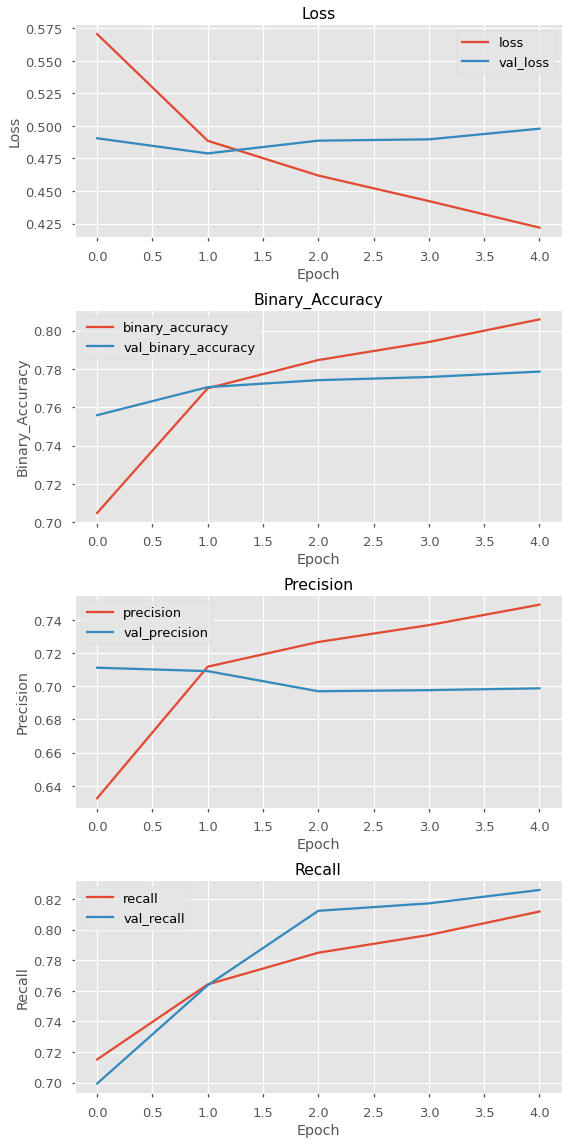

********************************************************************************
*                                 RNN - glove                                  *
********************************************************************************
   precision    recall  f1-score  support
0   0.856455  0.744770  0.796718     1434
1   0.698765  0.825875  0.757022     1028

   accuracy
   0.778635

              precision    recall  f1-score  support
macro avg      0.777610  0.785323  0.776870     2462
weighted avg   0.790613  0.778635  0.780143     2462


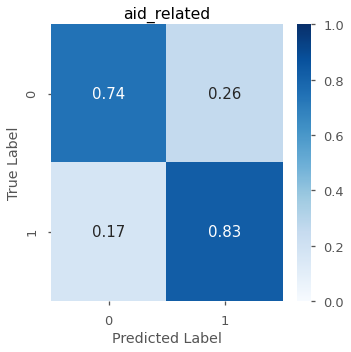

********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************


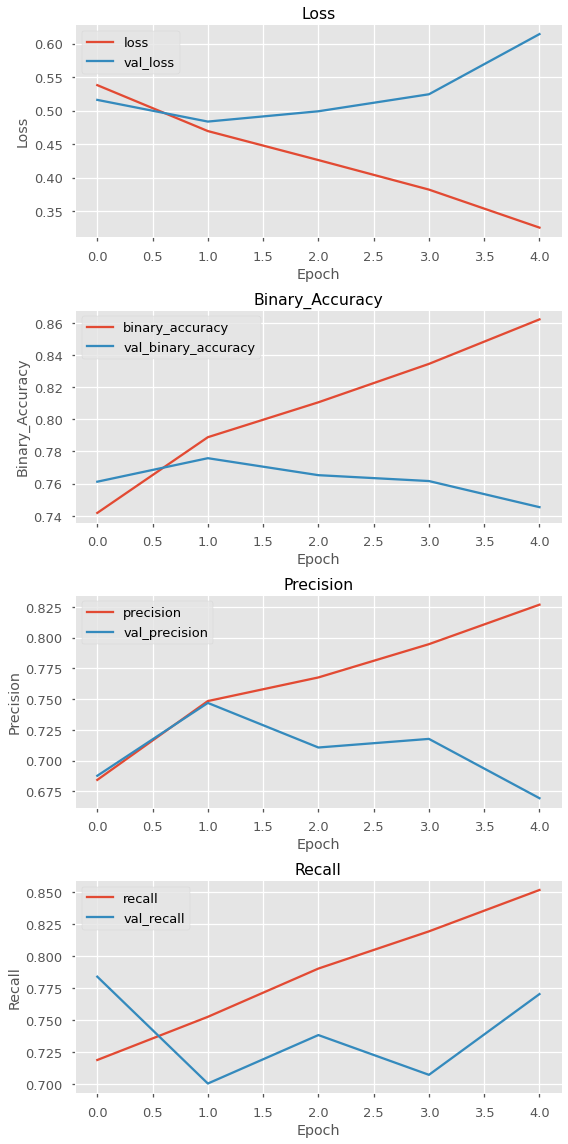

********************************************************************************
*                                  RNN - w2v                                   *
********************************************************************************
   precision    recall  f1-score  support
0   0.815481  0.727336  0.768891     1434
1   0.669484  0.770428  0.716418     1028

   accuracy
   0.745329

              precision    recall  f1-score  support
macro avg      0.742483  0.748882  0.742654     2462
weighted avg   0.754520  0.745329  0.746981     2462


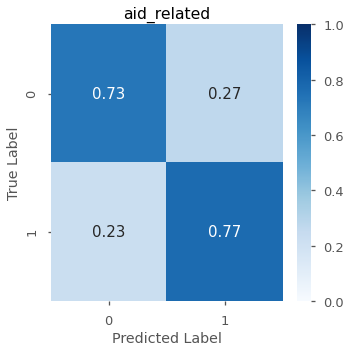

,NB_glove,RFC_glove,SVC_glove,LOGREG_glove,NB_w2v,RFC_w2v,SVC_w2v,LOGREG_w2v,simple_model_NN_glove,multilayer_model_NN_glove,simple_model_NN_w2v,multilayer_model_NN_w2v,RNN_glove,RNN_w2v
F1,0.687399,0.729583,0.770085,0.732658,0.722200,0.712071,0.756329,0.710856,0.754290,0.756849,0.752707,0.768911,0.794498,0.764531
Accuracy,0.694675,0.764892,0.787771,0.718738,0.728994,0.758185,0.757002,0.662722,0.768442,0.775937,0.774753,0.780671,0.805523,0.781065
Recall,0.748461,0.707124,0.792436,0.859279,0.785400,0.666667,0.840809,0.924362,0.792436,0.777485,0.764292,0.813544,0.838171,0.792436
Precision,0.635549,0.753515,0.748961,0.638562,0.668413,0.764113,0.687275,0.577473,0.719649,0.737281,0.741468,0.728920,0.755151,0.738525


In [85]:
for name in rnn_dct:
    y_test_pred = dis.evaluate_nn(rnn_dct[name]['model'], 
                                  rnn_dct[name]['history'], 
                                  X_val_tok, 
                                  dw.Y_val(), 
                                  X_test_tok, 
                                  header=f'RNN - {name}', 
                                  column_names=dw.target_columns)

    results_df = assign_scores(
        df=results_df, 
        column_name=f'RNN_{name}', 
        scores=dis.get_scores(dw.Y_test(), y_test_pred))

results_df

# Interpret

In [86]:
RESULTS = results_df.T

In [87]:
RESULTS.sort_values('F1', ascending=False, inplace=True)

In [88]:
RESULTS.style.background_gradient('Blues')

,F1,Accuracy,Recall,Precision
RNN_glove,0.794498,0.805523,0.838171,0.755151
SVC_glove,0.770085,0.787771,0.792436,0.748961
multilayer_model_NN_w2v,0.768911,0.780671,0.813544,0.72892
RNN_w2v,0.764531,0.781065,0.792436,0.738525
multilayer_model_NN_glove,0.756849,0.775937,0.777485,0.737281
SVC_w2v,0.756329,0.757002,0.840809,0.687275
simple_model_NN_glove,0.75429,0.768442,0.792436,0.719649
simple_model_NN_w2v,0.752707,0.774753,0.764292,0.741468
LOGREG_glove,0.732658,0.718738,0.859279,0.638562
RFC_glove,0.729583,0.764892,0.707124,0.753515


- Overall, **RNN_glove** (the RNN accompanied by the GloVe weights) performed clearly best overall.
 - On the test set:
   - 83.82% of `aid-related` messages were found.
   - 75.52% of `aid-related` predictions were correct.
   - 80.55% overall accuracy.
- **SVC_glove** (the SVC using Mean Word Embeddings and the GloVe model) performed exceptionally well, performing just below the **RNN_glove** in f1-score (better precision, but worse recall).
- The GloVe model lead to better results than the homemade *W2V* word embedder.
- **RNN_w2v** (an RNN accompanied by the homemade word vectorizer) performed very well also, showing the strength of an RNN model.

## Using the model

In [89]:
THE_MODEL = rnn_dct['glove']['model']

Below are some functions to use the model's predictions. 
> We will be using StreamLit and these functions to create a simple web app to deploy this model interactively.

You can test the model in the notebook below by changing the texts passed into the functions.

In [90]:
def prepare_text_for_model(text, tokenizer, max_length=65):
    """
    Transforms text data to a tokenized/padded version suitable for the model.
    
    Parameters:
    -----------
    text: string to analyze.
    tokenizer: Tokenizer object (pre-fit).
    
    Returns:
    --------
    Padded / Tokenized version of data.
    """
    tokenized_data = tokenizer.texts_to_sequences([text])
    padded_data = sequence.pad_sequences(tokenized_data, maxlen=max_length)
    return padded_data

In [91]:
def predict_with_model(processed_data, model):
    """
    Predict the processed data with the model.
    
    Returns (aid_related, y_pred)
    """
    y_pred = model.predict(processed_data)[0, 0]
    aid_related = int(y_pred >= 0.5)
    return aid_related, y_pred

In [92]:
def inference(text, tokenizer, model):
    processed_data = prepare_text_for_model(text, tokenizer)
    aid_related, y_pred = predict_with_model(processed_data, model)
    likelihood = f'(Likelihood aid-related: {round(y_pred*100, 3)}%)'
    if aid_related:
        return f'This message is aid-related. {likelihood}'
    return f'This message is not aid-related. {likelihood}'

In [93]:
# Change these texts if you like...
t1 = 'Please help me. We are out of food and water.'
t2 = 'It looks like a good day for sailing. Today I will enjoy the sunshine.'
t3 = 'adfgunali aidufgan bgnei siutm &$^&@@$*(((@)))'
t4 = 'Earthquakes are reported today from the islands. It is not clear the impact yet.'

In [94]:
for i, message in enumerate((t1, t2, t3, t4), 1):
    result = inference(message, tokenizer, THE_MODEL)
    print(f'Message {i}:\n{message}\n\t{result}\n')

Message 1:
Please help me. We are out of food and water.
	This message is aid-related. (Likelihood aid-related: 97.228%)

Message 2:
It looks like a good day for sailing. Today I will enjoy the sunshine.
	This message is not aid-related. (Likelihood aid-related: 7.221%)

Message 3:
adfgunali aidufgan bgnei siutm &$^&@@$*(((@)))
	This message is not aid-related. (Likelihood aid-related: 24.341%)

Message 4:
Earthquakes are reported today from the islands. It is not clear the impact yet.
	This message is not aid-related. (Likelihood aid-related: 9.447%)



### StreamLit
<a href="https://share.streamlit.io/cwf231/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/disaster_response_streamlit.py">Try the StreamLit app here!</a>

In [95]:
# # Open StreamLit app.
# !streamlit run disaster_response_streamlit.py

## Exploration

In [96]:
# Checking if there are trends to the model's incorrect predictions.
THE_y_pred = THE_MODEL.predict(X_test_tok)
THE_y_pred_binary = np.array([int(p >= 0.5) for p in THE_y_pred[:,0]])
THE_y_pred_binary

array([1, 1, 1, ..., 0, 1, 0])

In [97]:
correct_idx = []
incorrect_idx = []
for n, (t, p) in enumerate(zip(dw.Y_test(), THE_y_pred_binary)):
    if t == p:
        correct_idx.append(n)
        continue
    incorrect_idx.append(n)

correct_messages = dw.X_test()[correct_idx]
incorrect_messages = dw.X_test()[incorrect_idx]

len(correct_messages), len(incorrect_messages)

(2042, 493)

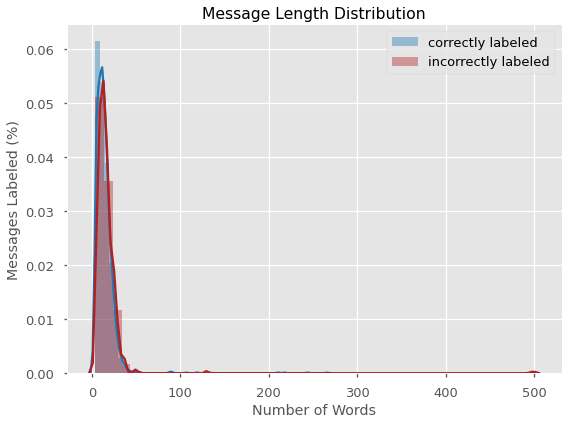

In [98]:
# Message length.
correct_messages_len = [len(x) for x in correct_messages]
incorrect_messages_len = [len(x) for x in incorrect_messages]

fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(correct_messages_len, color=COLORS['blue'], 
             label='correctly labeled', ax=ax)
sns.distplot(incorrect_messages_len, color=COLORS['red'], 
             label='incorrectly labeled', ax=ax)
ax.legend()
ax.set(title='Message Length Distribution', 
       xlabel='Number of Words', 
       ylabel='Messages Labeled (%)')
fig.tight_layout()

*Not much separation in the populations based on message length.*

In [99]:
# Common words.
word_freq_test = {}
for lst in dw.X_test():
    for word in lst:
        word_freq_test[word] = word_freq_test.get(word, 0) + 1
        
top_10_test_freq = sorted(list(word_freq_test.items()), 
                          key=lambda x: -x[1])[:10]
top_10_test_freq

[("'s", 300),
 ('people', 298),
 ('food', 294),
 ('water', 288),
 ('need', 268),
 ('help', 248),
 ('please', 189),
 ("n't", 172),
 ('earthquake', 169),
 ('area', 152)]

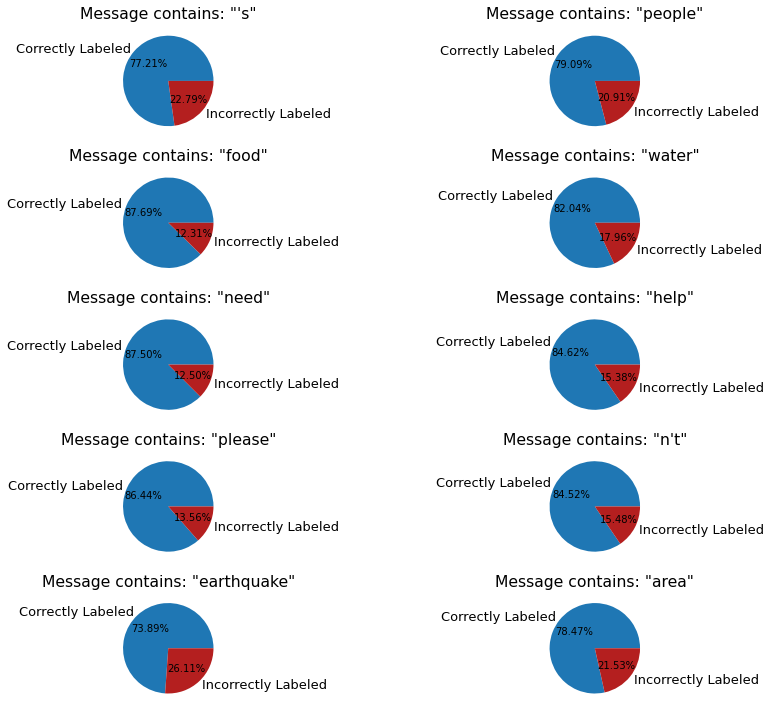

In [100]:
fig, ax_lst = plt.subplots(nrows=5, ncols=2, figsize=(12,10))
for (word, _), ax in zip(top_10_test_freq, ax_lst.flatten()):
    correct_messages_has_word = sum([int(word in m) 
                                     for m in correct_messages])
    incorrect_messages_has_word = sum([int(word in m) 
                                       for m in incorrect_messages])
    num_messages_with_word = correct_messages_has_word + \
                             incorrect_messages_has_word
    ax.pie([correct_messages_has_word, incorrect_messages_has_word],
           labels=['Correctly Labeled', 'Incorrectly Labeled'],
           colors=[COLORS['blue'], COLORS['red']],
           autopct=lambda p: f'{p:.2f}%')
    ax.set(title=f'Message contains: "{word}"')
fig.tight_layout()

# Conclusion
## Best Model
- The RNN model using GloVe embeddings performed best overall.
 - On the test set:
   - 83.82% of `aid-related` messages were found.
   - 75.52% of `aid-related` predictions were correct.
   - 80.55% overall accuracy.
   
## For the future
- Include the multitude of other labels to further identify the messages.
- Experiment with more RNN architectures to try to get better results.